In [1]:
####### Module to retrieve pickled data######
from sklearn.utils import shuffle
from preprocess import load_data
########## Plotting Data ########
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
from tqdm import trange
import time
from datetime import datetime
import cv2

####### Mathematical & Array Operations #########
import numpy as np
import math
from random import randint
from collections import namedtuple
import itertools
import pandas as pd

# Tensor FLow for Neural Network Frameworks
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from tensorflow.contrib.layers import apply_regularization
from tensorflow.contrib.layers import l1_regularizer
from tensorflow.contrib.layers import xavier_initializer
from spatial_transformer import transformer
from sklearn.metrics import confusion_matrix

%matplotlib inline

Modules Imported


In [2]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

tf.reset_default_graph()
########## Graph Inputs #########################
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int64, (None))
num_classes = 43
reg_fac = tf.placeholder(tf.float32, None)
rate = tf.placeholder(tf.float32, None)
is_training = tf.placeholder(tf.bool, None)

In [3]:
############################# Batch Normalization Layer ##################
def batch_norm(input_, name, n_out, phase_train):
    with tf.variable_scope(name + 'bn'):
        beta = tf.Variable(tf.constant(
            0.0, shape=[n_out]), name=name + 'beta', trainable=True)
        gamma = tf.Variable(tf.constant(
            1.0, shape=[n_out]), name=name + 'gamma', trainable=True)
        if len(input_.get_shape().as_list()) > 3:
            batch_mean, batch_var = tf.nn.moments(
                input_, [0, 1, 2], name=name + 'moments')
        else:
            batch_mean, batch_var = tf.nn.moments(
                input_, [0, 1], name=name + 'moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.5)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train, mean_var_with_update, lambda: (
            ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(
            input_, mean, var, beta, gamma, 1e-3)

    variable_summaries(beta)
    variable_summaries(gamma)
    return normed

############################## Parametric ReLU Activation  Layer #########


def parametric_relu(input_, name):
    alpha = tf.get_variable(name=name + '_alpha', shape=input_.get_shape(
    )[-1], initializer=tf.random_uniform_initializer(minval=0.1, maxval=0.3), dtype=tf.float32)
    pos = tf.nn.relu(input_)
    tf.summary.histogram(name, pos)
    neg = alpha * (input_ - abs(input_)) * 0.5
    return pos + neg


# Convolutional Layer with activation and batc
def conv(input_, name, k1, k2, n_o, reg_fac, is_tr, s1=1, s2=1, is_act=True, is_bn=True, padding='SAME'):

    n_i = input_.get_shape()[-1].value
    with tf.variable_scope(name):
        weights = tf.get_variable(name + "weights", [k1, k2, n_i, n_o], tf.float32, xavier_initializer(
        ), regularizer=tf.contrib.layers.l2_regularizer(reg_fac))
        biases = tf.get_variable(name +
                                 "bias", [n_o], tf.float32, tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(input_, weights, (1, s1, s2, 1), padding=padding)
        bn = batch_norm(conv, name, n_o, is_tr) if is_bn else conv
        activation = parametric_relu(tf.nn.bias_add(
            bn, biases), name + "activation") if is_act else tf.nn.bias_add(bn, biases)
        variable_summaries(weights)
        variable_summaries(biases)
    return activation

# Fully connected Layer with activation and ba


def fc(input_, name, n_o, reg_fac, is_tr, p_fc, is_act=True, is_bn=True):
    n_i = input_.get_shape()[-1].value
    with tf.variable_scope(name):
        weights = tf.get_variable(name + "weights", [n_i, n_o], tf.float32, xavier_initializer(
        ),  regularizer=tf.contrib.layers.l2_regularizer(reg_fac))
        biases = tf.get_variable(
            name + "bias", [n_o], tf.float32, tf.constant_initializer(0.0))
        bn = tf.nn.bias_add(tf.matmul(input_, weights), biases)
        activation = batch_norm(bn, name, n_o, is_tr) if is_bn else bn
        logits = parametric_relu(
            activation, name + "activation") if is_act else activation
        
        variable_summaries(weights)
        variable_summaries(biases)

    return tf.cond(is_tr, lambda: tf.nn.dropout(logits, keep_prob=p_fc), lambda: logits)

############################# Max Pooling Layer with activation ##########


def pool(input_, name, k1, k2, s1=2, s2=2):
    return tf.nn.max_pool(input_, ksize=[1, k1, k2, 1], strides=[1, s1, s2, 1], padding='VALID', name=name)

In [4]:
############################# Localization Layer for Spatial Transformer L
def localization_net(input_, name, is_tr, reg_fac):
    # Identity transformation
    initial = np.array([[1., 0, 0], [0, 1., 0]])
    initial = initial.astype('float32')
    initial = initial.flatten()
    # Weight and Bias containing the identity transformation
    W = tf.get_variable('loc_weights', [64, 6], tf.float32, xavier_initializer(
    ), regularizer=tf.contrib.layers.l2_regularizer(reg_fac))
    b = tf.Variable(initial_value=initial, name='loc_bias')

    ############ Localization Network for the Spatial transformer network ####
    ##################### 7x7x16 Conv -> 2x2 Max pooling ###################
    locnet = conv(input_, name="locnet_conv1", k1=3, k2=3, n_o=16,
                  reg_fac=reg_fac, is_tr=is_tr, padding='SAME')
    locnet = pool(locnet, name="locnet_pool1", k1=2, k2=2)

    ###################### 5x5x32 Conv -> 2x2 Max pooling ###################
    locnet = conv(locnet, name="locnet_conv2", k1=3, k2=3, n_o=32,
                  reg_fac=reg_fac, is_tr=is_tr, padding='SAME')
    locnet = pool(locnet, name="locnet_pool2", k1=2, k2=2)

    ###################### 3x3x64 Conv -> 2x2 Max pooling ####################
    locnet = conv(locnet, name="locnet_conv3", k1=3, k2=3, n_o=64,
                  reg_fac=reg_fac, is_tr=is_tr, padding='SAME')
    locnet = pool(locnet, name="locnet_pool3", k1=2, k2=2)
    
    ###################### 3x3x64 Conv -> 2x2 Max pooling ####################
    locnet = conv(locnet, name="locnet_conv4", k1=3, k2=3, n_o=128,
                  reg_fac=reg_fac, is_tr=is_tr, padding='SAME')
    locnet = pool(locnet, name="locnet_pool4", k1=2, k2=2)

    ####################### Fully Connected Layers ###########################
    locnet_fc0 = flatten(locnet)
    locnet_fc1 = fc(locnet_fc0, name="locnet_fc1", n_o=128,
                    reg_fac=reg_fac, is_tr=is_tr, p_fc=.50)
    locnet_fc2 = fc(locnet_fc1, name="locnet_fc2", n_o=64,
                    reg_fac=reg_fac, is_tr=is_tr, p_fc=.50)
    locnet_op = tf.nn.bias_add(tf.matmul(locnet_fc2, W), b)

    return locnet_op

In [5]:
def VGG_Layer(input_, name, conv_size, n_layers, pool_size, n_o, reg_fac, is_tr, p_vgg):

    n_i = input_.get_shape()[-1].value
    c_k1 = conv_size
    c_k2 = conv_size
    p_k1 = pool_size
    p_k2 = pool_size

    vgg = input_
    for i in range(n_layers):
        ############## VGG Building Block ###############################
        ############## 2 - Conv , 1- Pool 1- Dropout 1 - Batch-Norm ###########
        vgg = conv(vgg, name=name + "conv1_" + str(i), k1=c_k1,
                   k2=c_k2, n_o=n_o, reg_fac=reg_fac, is_tr=is_tr)

    vgg = pool(vgg, name=name + "pool1", k1=p_k1, k2=p_k2)
    vgg = tf.cond(is_tr, lambda: tf.nn.dropout(
        vgg, keep_prob=p_vgg), lambda: vgg)
    return vgg

In [6]:
def run_model(input_, num_classes, params, reg_fac, is_training):

    ############## Spatial Transformer Module ######################
    ##################### Localization layer #######################
    locnet = localization_net(input_, name="locnet",
                              reg_fac=reg_fac, is_tr=is_training)
    ####################### Affine Transformation Layer ############
    stn = transformer(input_, locnet, out_size=(32, 32, 3))
    stn_= tf.reshape(stn,(-1,32,32,3))
    ################################## VGG Net ###############################
    ################################# VGG- Layer - 1 #########################
    vgg1 = VGG_Layer(stn_, "vgg1", conv_size=3, n_layers=2, pool_size=2, n_o=32,
                     reg_fac=reg_fac, is_tr=is_training, p_vgg=params.vgg1)
    variable_summaries(vgg1)
    ################################# VGG- Layer - 2 #########################
    vgg2 = VGG_Layer(vgg1, "vgg2", conv_size=3,  n_layers=2, pool_size=2, n_o=64,
                     reg_fac=reg_fac, is_tr=is_training, p_vgg=params.vgg2)
    variable_summaries(vgg2)
    ################################# VGG- Layer - 3 #########################
    vgg3 = VGG_Layer(vgg2, "vgg3", conv_size=3,  n_layers=3, pool_size=2, n_o=128,
                     reg_fac=reg_fac, is_tr=is_training, p_vgg=params.vgg3)
    variable_summaries(vgg3)
    ################################# VGG- Layer - 4 #########################
    vgg4 = VGG_Layer(vgg3, "vgg4", conv_size=3,  n_layers=3, pool_size=2, n_o=256,
                     reg_fac=reg_fac, is_tr=is_training, p_vgg=params.vgg4)
    variable_summaries(vgg4)
    ################################ Multi Scale Convolution layer ###########
    ms1 = pool(vgg2, "ms1", k1=2, k2=2)
    ms2 = tf.concat([ms1,vgg3], axis=3)
    
    ms3 = pool(ms2, "ms3", k1=2, k2=2)
    ms = tf.concat([ms3, vgg4], axis=3)

    
    ################## Fully Connected Layers for a Linear Classifier ########
    #############################First Fully Connected Layer #################
    fc0 = fc(flatten(ms), "fc0", 1024, reg_fac=reg_fac,
             is_tr=is_training, p_fc=params.fc0)
    fc1 = fc(fc0, "fc1", 512, reg_fac=reg_fac,
             is_tr=is_training, p_fc=params.fc1)
    ########################### Output readout Layer #########################
    fc2 = fc(fc1, "fc2", num_classes, reg_fac=reg_fac,
             is_tr=is_training, p_fc=1.0, is_act=False, is_bn=True)

    return fc2

In [7]:
params = namedtuple('params', 'vgg1 vgg2 vgg3 vgg4 ms fc0 fc1')
mdltype = params(vgg1=.5, vgg2=.5, vgg3=.5, vgg4=.5, ms=.5, fc0=.5, fc1=.5)
logits = run_model(x, num_classes, mdltype, reg_fac, is_training)
tf.summary.histogram('Logits', logits)

# For Top 5 Guesses
prediction = tf.nn.softmax(logits)
top5_guesses = tf.nn.top_k(prediction, k=5, sorted=True)


# Predicted Label and Actual Label using Argmax
y_pred = tf.argmax(logits, 1)

# Accuracy Calculation
correct_prediction = tf.equal(y_pred, y)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('Accuracy', accuracy_operation)

######### Cross Entropy and Loss for Training ##########
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=logits, labels=y, name='cross_entropy')
loss_operation = tf.reduce_mean(
    cross_entropy) + tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
tf.summary.scalar('Loss', loss_operation)

########### Training Step ################
Train_Step = tf.train.AdamOptimizer(rate).minimize(loss_operation)
summary = tf.summary.merge_all()

In [8]:
def evaluate(X_data, y_data, batch_size, is_tr):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        bx, by = X_data[offset:offset +
                        batch_size], y_data[offset:offset + batch_size]
        inputs_ = {x: bx, y: by, is_training: is_tr}
        accuracy = sess.run(accuracy_operation, feed_dict=inputs_)
        total_accuracy += (accuracy * len(bx))
    return total_accuracy / num_examples

def plot_confusion_matrix(X_data,y_data, batch_size, is_tr, normalize=True):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    offset=randint(0,num_examples-batch_size)
    bx, by = X_data[offset:offset +
                    batch_size], y_data[offset:offset + batch_size]
    inputs_ = {x: bx, y: by, is_training: is_tr}
    cm_input = sess.run(y_pred,feed_dict=inputs_)
    cm = confusion_matrix(y_true = by,y_pred = cm_input)
    if normalize is True:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
    
    plt.figure(figsize=(25,25))  
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(num_classes)
    
    df=pd.read_csv("signnames.csv")
    plt.xticks(range(num_classes), df['SignName'])
    plt.yticks(range(num_classes), df['SignName'])
    plt.xticks(rotation=90)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlabel('Predicted', fontsize = 24)
    plt.ylabel('True', fontsize= 24)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.show()

In [9]:
# training_file = 'train_processed'
# validation_file = 'valid_processed'
# testing_file = 'test_processed'
training_file = 'train.pickle'
validation_file = 'valid.pickle'
testing_file = 'test.pickle'
X_train,y_train = load_data(training_file)
X_valid,y_valid = load_data(validation_file)
X_test,y_test = load_data(testing_file)

Data and Modules loaded
Data and Modules loaded
Data and Modules loaded


In [12]:
BATCH_SIZE = 100
EPOCHS = 50
REG_FACTOR = 2e-5
RATE = 1e-4
now_datetime = datetime.now().strftime("%y%m%d")
save_file = "VGGNet_" + now_datetime
restore_file ="VGGNet_" + now_datetime
chkpt = './' + save_file
chkpt_restore = './' + restore_file
logdir = chkpt + datetime.now().strftime('%Y%m%d-%H%M%S') + '/'
is_restore= False

In [13]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
# sess = tf.Session()
with tf.Session(config=config) as sess:
    sess.run(init)
    ##################  Start Model Training  #######################
    if is_restore:
        saver.restore(sess,chkpt_restore)
    summary_writer = tf.summary.FileWriter(logdir, sess.graph)
    print("Training...")
    print()
    val_acc = []
    for i in range(EPOCHS):
        
        ############ Training Operation ################
        Training_loss = 0
        X_train, y_train = shuffle(X_train, y_train)
        for offset in trange(0, len(X_train), BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            inputs = {x: batch_x, y: batch_y, reg_fac: REG_FACTOR,
                      rate: RATE, is_training: True}
            loss, _ = sess.run([loss_operation, Train_Step], feed_dict=inputs)
            Training_loss += (loss * len(batch_x))

        ################ Evaluation operation ####################
        Validation_Accuracy = evaluate(X_valid, y_valid, 1000, is_tr=False)
        val_acc.append(Validation_Accuracy)
        Training_loss /= len(X_train)
        print("Epochs:", i + 1)
        print("Training_Loss:", Training_loss)
        print("Validation_Accuracy:", Validation_Accuracy)
        
        
        ##### Save Model if the Validation accuracy gets better
        if (max(val_acc) == Validation_Accuracy):
            saver.save(sess, chkpt)
            print("Intermediate Model Save")
            summary_str = sess.run(summary, feed_dict=inputs)
            summary_writer.add_summary(summary_str, i)
            
print("Model saved")


  0%|          | 0/348 [00:00<?, ?it/s]

Training...




100%|██████████| 348/348 [00:57<00:00,  6.01it/s]


Epochs: 1
Training_Loss: 3.597792855727028
Validation_Accuracy: 0.04784580649567299
Intermediate Model Save



100%|██████████| 348/348 [00:54<00:00,  6.33it/s]


Epochs: 2
Training_Loss: 3.3928838414040623
Validation_Accuracy: 0.09841269785179302
Intermediate Model Save



100%|██████████| 348/348 [00:53<00:00,  6.46it/s]


Epochs: 3
Training_Loss: 3.172172570551273
Validation_Accuracy: 0.1213151910141651
Intermediate Model Save



100%|██████████| 348/348 [00:52<00:00,  6.59it/s]


Epochs: 4
Training_Loss: 2.9212233739740707
Validation_Accuracy: 0.19274376261801945
Intermediate Model Save



100%|██████████| 348/348 [00:52<00:00,  6.58it/s]


Epochs: 5
Training_Loss: 2.6379658151054532
Validation_Accuracy: 0.3106575950203028
Intermediate Model Save



100%|██████████| 348/348 [00:52<00:00,  6.57it/s]


Epochs: 6
Training_Loss: 2.3411955781365137
Validation_Accuracy: 0.3435374105395644
Intermediate Model Save



100%|██████████| 348/348 [00:52<00:00,  6.57it/s]


Epochs: 7
Training_Loss: 2.1207105262159134
Validation_Accuracy: 0.43945577865690333
Intermediate Model Save



100%|██████████| 348/348 [00:53<00:00,  6.46it/s]


Epochs: 8
Training_Loss: 1.8856514259304014
Validation_Accuracy: 0.5092970524109951
Intermediate Model Save



100%|██████████| 348/348 [00:53<00:00,  6.54it/s]


Epochs: 9
Training_Loss: 1.6064392772432463
Validation_Accuracy: 0.6172335508053535
Intermediate Model Save



100%|██████████| 348/348 [00:53<00:00,  6.55it/s]


Epochs: 10
Training_Loss: 1.3346834728411483
Validation_Accuracy: 0.7210884356444656
Intermediate Model Save



100%|██████████| 348/348 [00:53<00:00,  6.55it/s]


Epochs: 11
Training_Loss: 1.0952523640645757
Validation_Accuracy: 0.7702947896894684
Intermediate Model Save



100%|██████████| 348/348 [00:53<00:00,  6.54it/s]


Epochs: 12
Training_Loss: 0.9074887931783664
Validation_Accuracy: 0.8004535155501765
Intermediate Model Save



100%|██████████| 348/348 [00:53<00:00,  6.54it/s]


Epochs: 13
Training_Loss: 0.7624426592684035
Validation_Accuracy: 0.8392290293224274
Intermediate Model Save



100%|██████████| 348/348 [00:53<00:00,  6.55it/s]


Epochs: 14
Training_Loss: 0.6552977842203334
Validation_Accuracy: 0.8823129102216015
Intermediate Model Save



100%|██████████| 348/348 [00:53<00:00,  6.54it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 15
Training_Loss: 0.5823984461492319
Validation_Accuracy: 0.8818594119986709



100%|██████████| 348/348 [00:53<00:00,  6.54it/s]


Epochs: 16
Training_Loss: 0.5186320997410839
Validation_Accuracy: 0.894557820831567
Intermediate Model Save



100%|██████████| 348/348 [00:53<00:00,  6.54it/s]


Epochs: 17
Training_Loss: 0.44964607459772094
Validation_Accuracy: 0.895918369158055
Intermediate Model Save



100%|██████████| 348/348 [00:53<00:00,  6.55it/s]


Epochs: 18
Training_Loss: 0.39507790674316856
Validation_Accuracy: 0.9290249488251009
Intermediate Model Save



100%|██████████| 348/348 [00:53<00:00,  6.55it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 19
Training_Loss: 0.3647262101576052
Validation_Accuracy: 0.9276644032017715



100%|██████████| 348/348 [00:53<00:00,  6.55it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 20
Training_Loss: 0.33882649107350576
Validation_Accuracy: 0.9208616641373321



100%|██████████| 348/348 [00:53<00:00,  6.55it/s]


Epochs: 21
Training_Loss: 0.3139843849706706
Validation_Accuracy: 0.9378684778062124
Intermediate Model Save



100%|██████████| 348/348 [00:53<00:00,  6.56it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 22
Training_Loss: 0.3038947104708882
Validation_Accuracy: 0.9328798175939357



100%|██████████| 348/348 [00:55<00:00,  6.27it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 23
Training_Loss: 0.2709251953267877
Validation_Accuracy: 0.9342403660555816



100%|██████████| 348/348 [00:54<00:00,  6.40it/s]


Epochs: 24
Training_Loss: 0.268591294592936
Validation_Accuracy: 0.9596371807478994
Intermediate Model Save



100%|██████████| 348/348 [00:53<00:00,  6.56it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 25
Training_Loss: 0.26312407378907304
Validation_Accuracy: 0.9145124826301523



100%|██████████| 348/348 [00:53<00:00,  6.55it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 26
Training_Loss: 0.2544979507751707
Validation_Accuracy: 0.9310657659085159



100%|██████████| 348/348 [00:53<00:00,  6.55it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 27
Training_Loss: 0.22481006844517706
Validation_Accuracy: 0.9401360492046729



100%|██████████| 348/348 [00:53<00:00,  6.55it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 28
Training_Loss: 0.21782805084284668
Validation_Accuracy: 0.9471655425841576



100%|██████████| 348/348 [00:53<00:00,  6.55it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 29
Training_Loss: 0.20225222569905654
Validation_Accuracy: 0.9435374119114173



100%|██████████| 348/348 [00:53<00:00,  6.45it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 30
Training_Loss: 0.22180619879316546
Validation_Accuracy: 0.9455782344011493



100%|██████████| 348/348 [00:53<00:00,  6.54it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 31
Training_Loss: 0.18536137429858532
Validation_Accuracy: 0.9539682627264875



100%|██████████| 348/348 [00:53<00:00,  6.54it/s]


Epochs: 32
Training_Loss: 0.17695076155619374
Validation_Accuracy: 0.9598639487138951
Intermediate Model Save



100%|██████████| 348/348 [00:53<00:00,  6.53it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 33
Training_Loss: 0.18082299482880998
Validation_Accuracy: 0.9528344634438859



100%|██████████| 348/348 [00:53<00:00,  6.54it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 34
Training_Loss: 0.180426257259613
Validation_Accuracy: 0.9473922835185684



100%|██████████| 348/348 [00:53<00:00,  6.54it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 35
Training_Loss: 0.16705794924792897
Validation_Accuracy: 0.9566893186969281



100%|██████████| 348/348 [00:53<00:00,  6.54it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 36
Training_Loss: 0.17087779276096746
Validation_Accuracy: 0.9394557777445873



100%|██████████| 348/348 [00:55<00:00,  6.30it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 37
Training_Loss: 0.16529906566565966
Validation_Accuracy: 0.9487528346833729



100%|██████████| 348/348 [00:53<00:00,  6.55it/s]


Epochs: 38
Training_Loss: 0.15198867263386362
Validation_Accuracy: 0.9641723480084046
Intermediate Model Save



100%|██████████| 348/348 [00:53<00:00,  6.55it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 39
Training_Loss: 0.15952351324549488
Validation_Accuracy: 0.941269845648958



100%|██████████| 348/348 [00:53<00:00,  6.55it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 40
Training_Loss: 0.1542283992343718
Validation_Accuracy: 0.9637188176178878



100%|██████████| 348/348 [00:53<00:00,  6.55it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 41
Training_Loss: 0.14490539713349027
Validation_Accuracy: 0.9360544259856347



100%|██████████| 348/348 [00:53<00:00,  6.55it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 42
Training_Loss: 0.13654230151871105
Validation_Accuracy: 0.9587301467281351



100%|██████████| 348/348 [00:54<00:00,  6.44it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 43
Training_Loss: 0.15367112610390748
Validation_Accuracy: 0.9578231260890052



100%|██████████| 348/348 [00:53<00:00,  6.53it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 44
Training_Loss: 0.13466624334052452
Validation_Accuracy: 0.9383219865714612



100%|██████████| 348/348 [00:53<00:00,  6.53it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 45
Training_Loss: 0.13190245078903645
Validation_Accuracy: 0.9562358369632643



100%|██████████| 348/348 [00:53<00:00,  6.53it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 46
Training_Loss: 0.12746959070811112
Validation_Accuracy: 0.9598639593913711



100%|██████████| 348/348 [00:53<00:00,  6.54it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 47
Training_Loss: 0.13832679677720064
Validation_Accuracy: 0.9342403686235822



100%|██████████| 348/348 [00:53<00:00,  6.53it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 48
Training_Loss: 0.1271644450601872
Validation_Accuracy: 0.9464852576082796



100%|██████████| 348/348 [00:53<00:00,  6.53it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

Epochs: 49
Training_Loss: 0.11862037775322892
Validation_Accuracy: 0.9555555465810693



100%|██████████| 348/348 [00:53<00:00,  6.53it/s]


Epochs: 50
Training_Loss: 0.12012105389850133
Validation_Accuracy: 0.9671201857309493
Intermediate Model Save
Model saved


INFO:tensorflow:Restoring parameters from ./VGGNet_180522


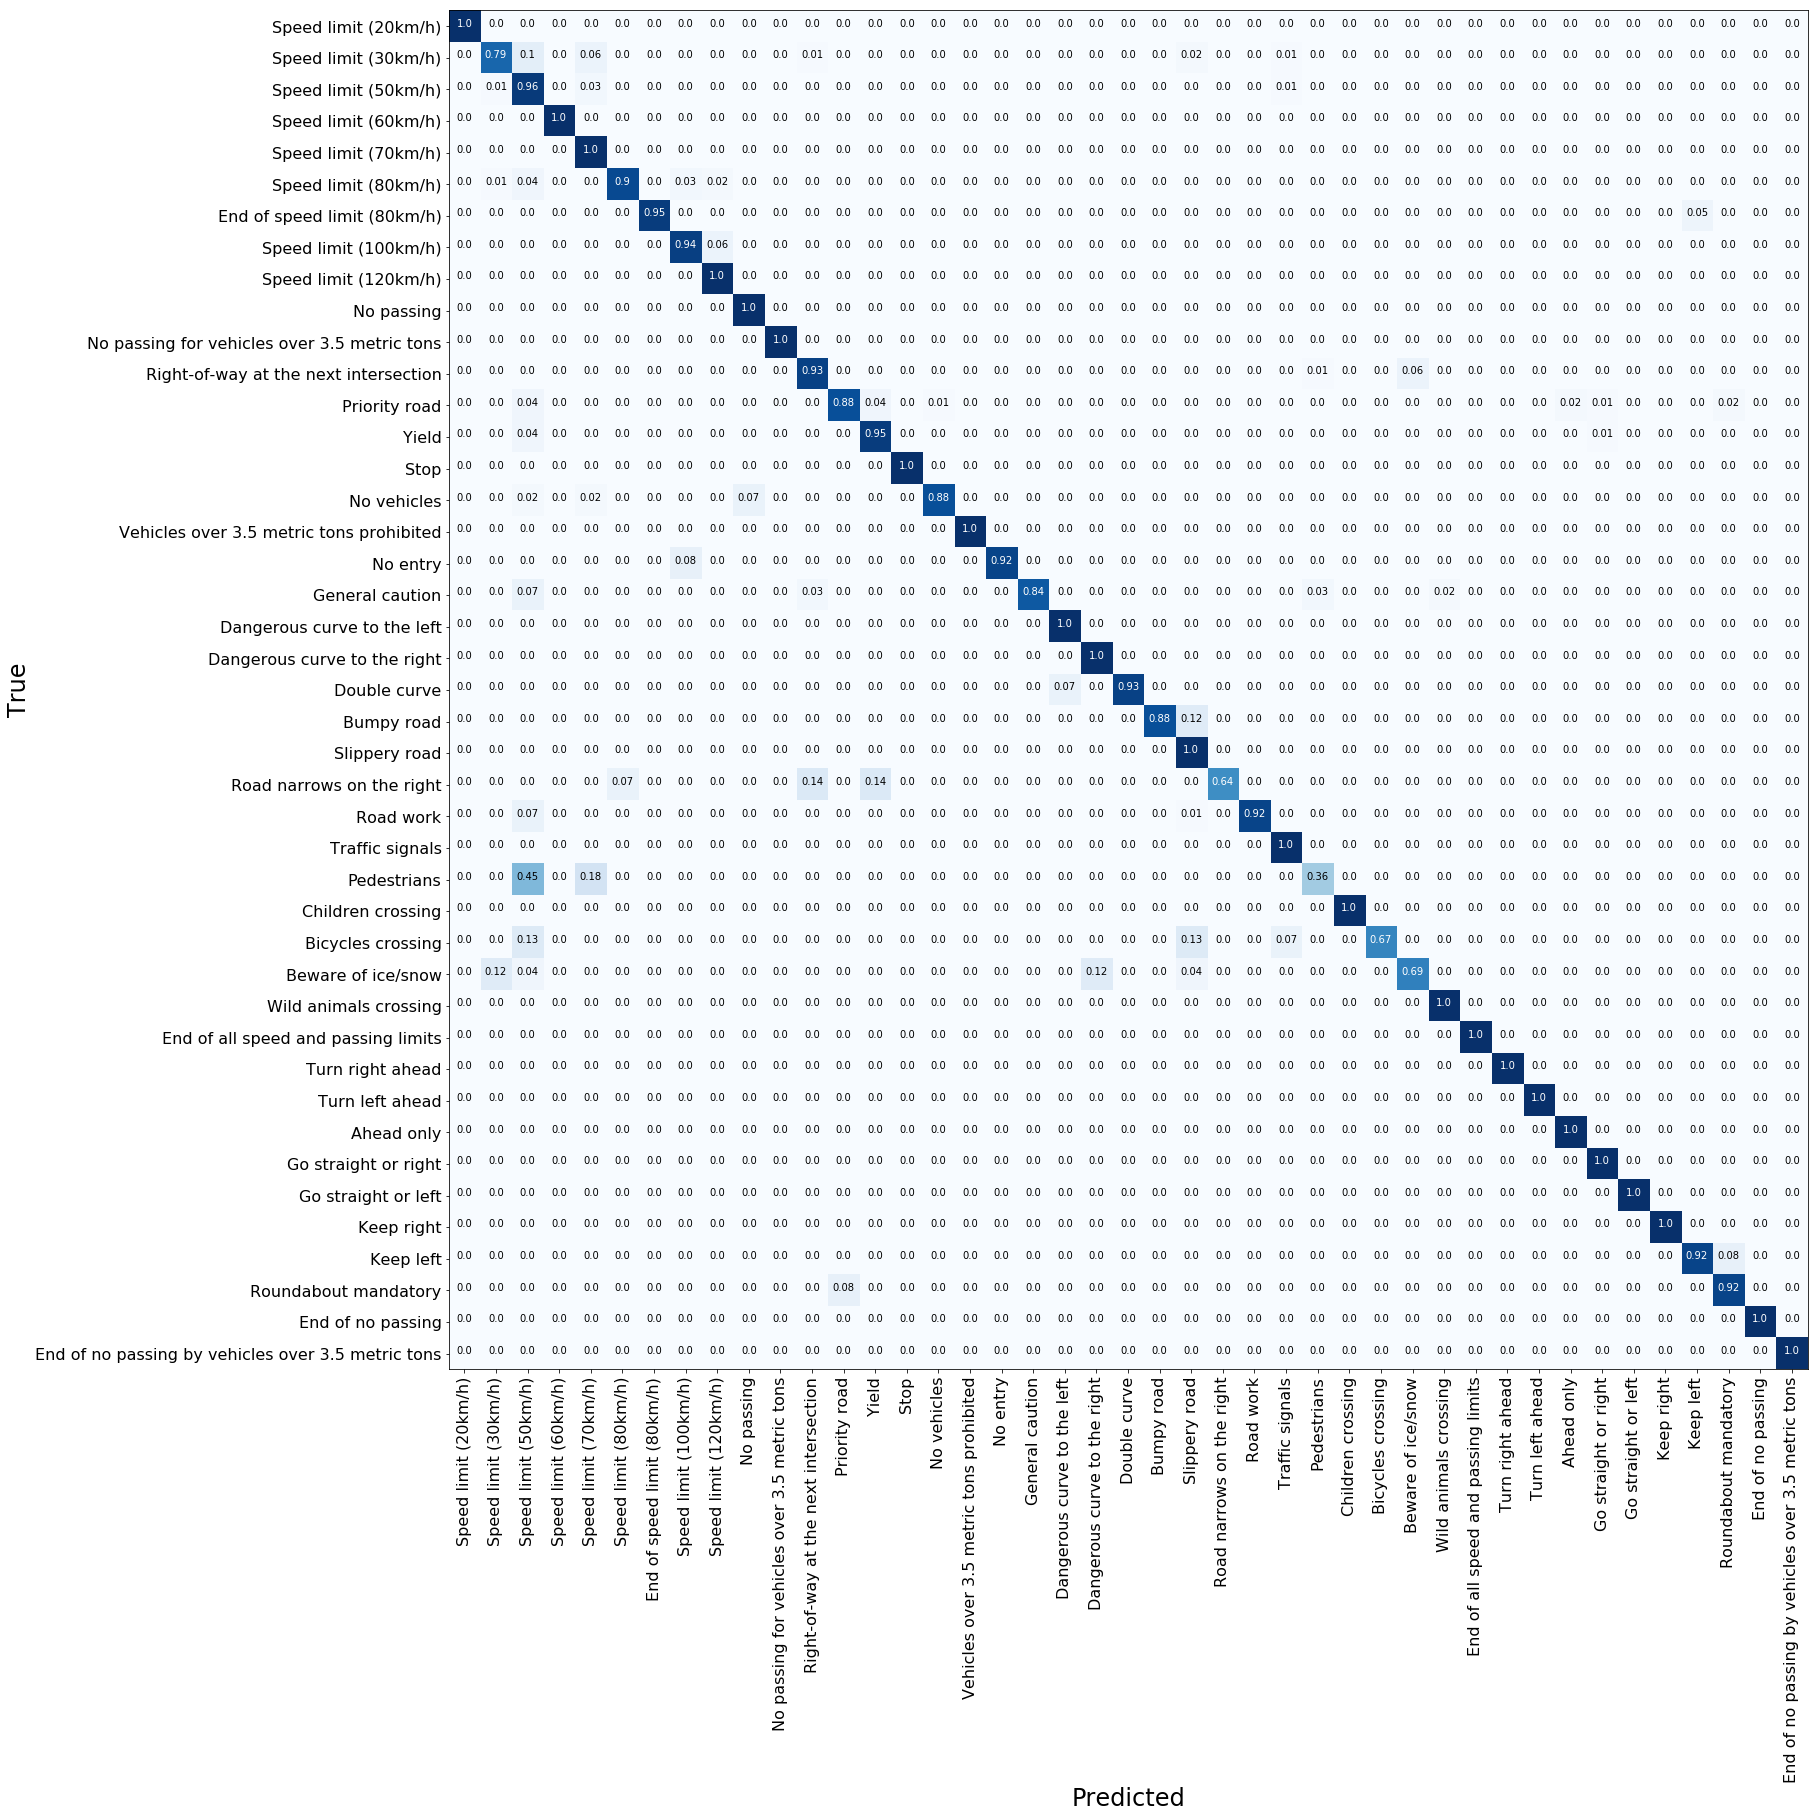

Test Accuracy = 0.946


In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
saver=tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess,chkpt)
    test_accuracy = evaluate(X_test, y_test, 500, False)
    plot_confusion_matrix(X_test, y_test, 2000, False)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./VGGNet_180522


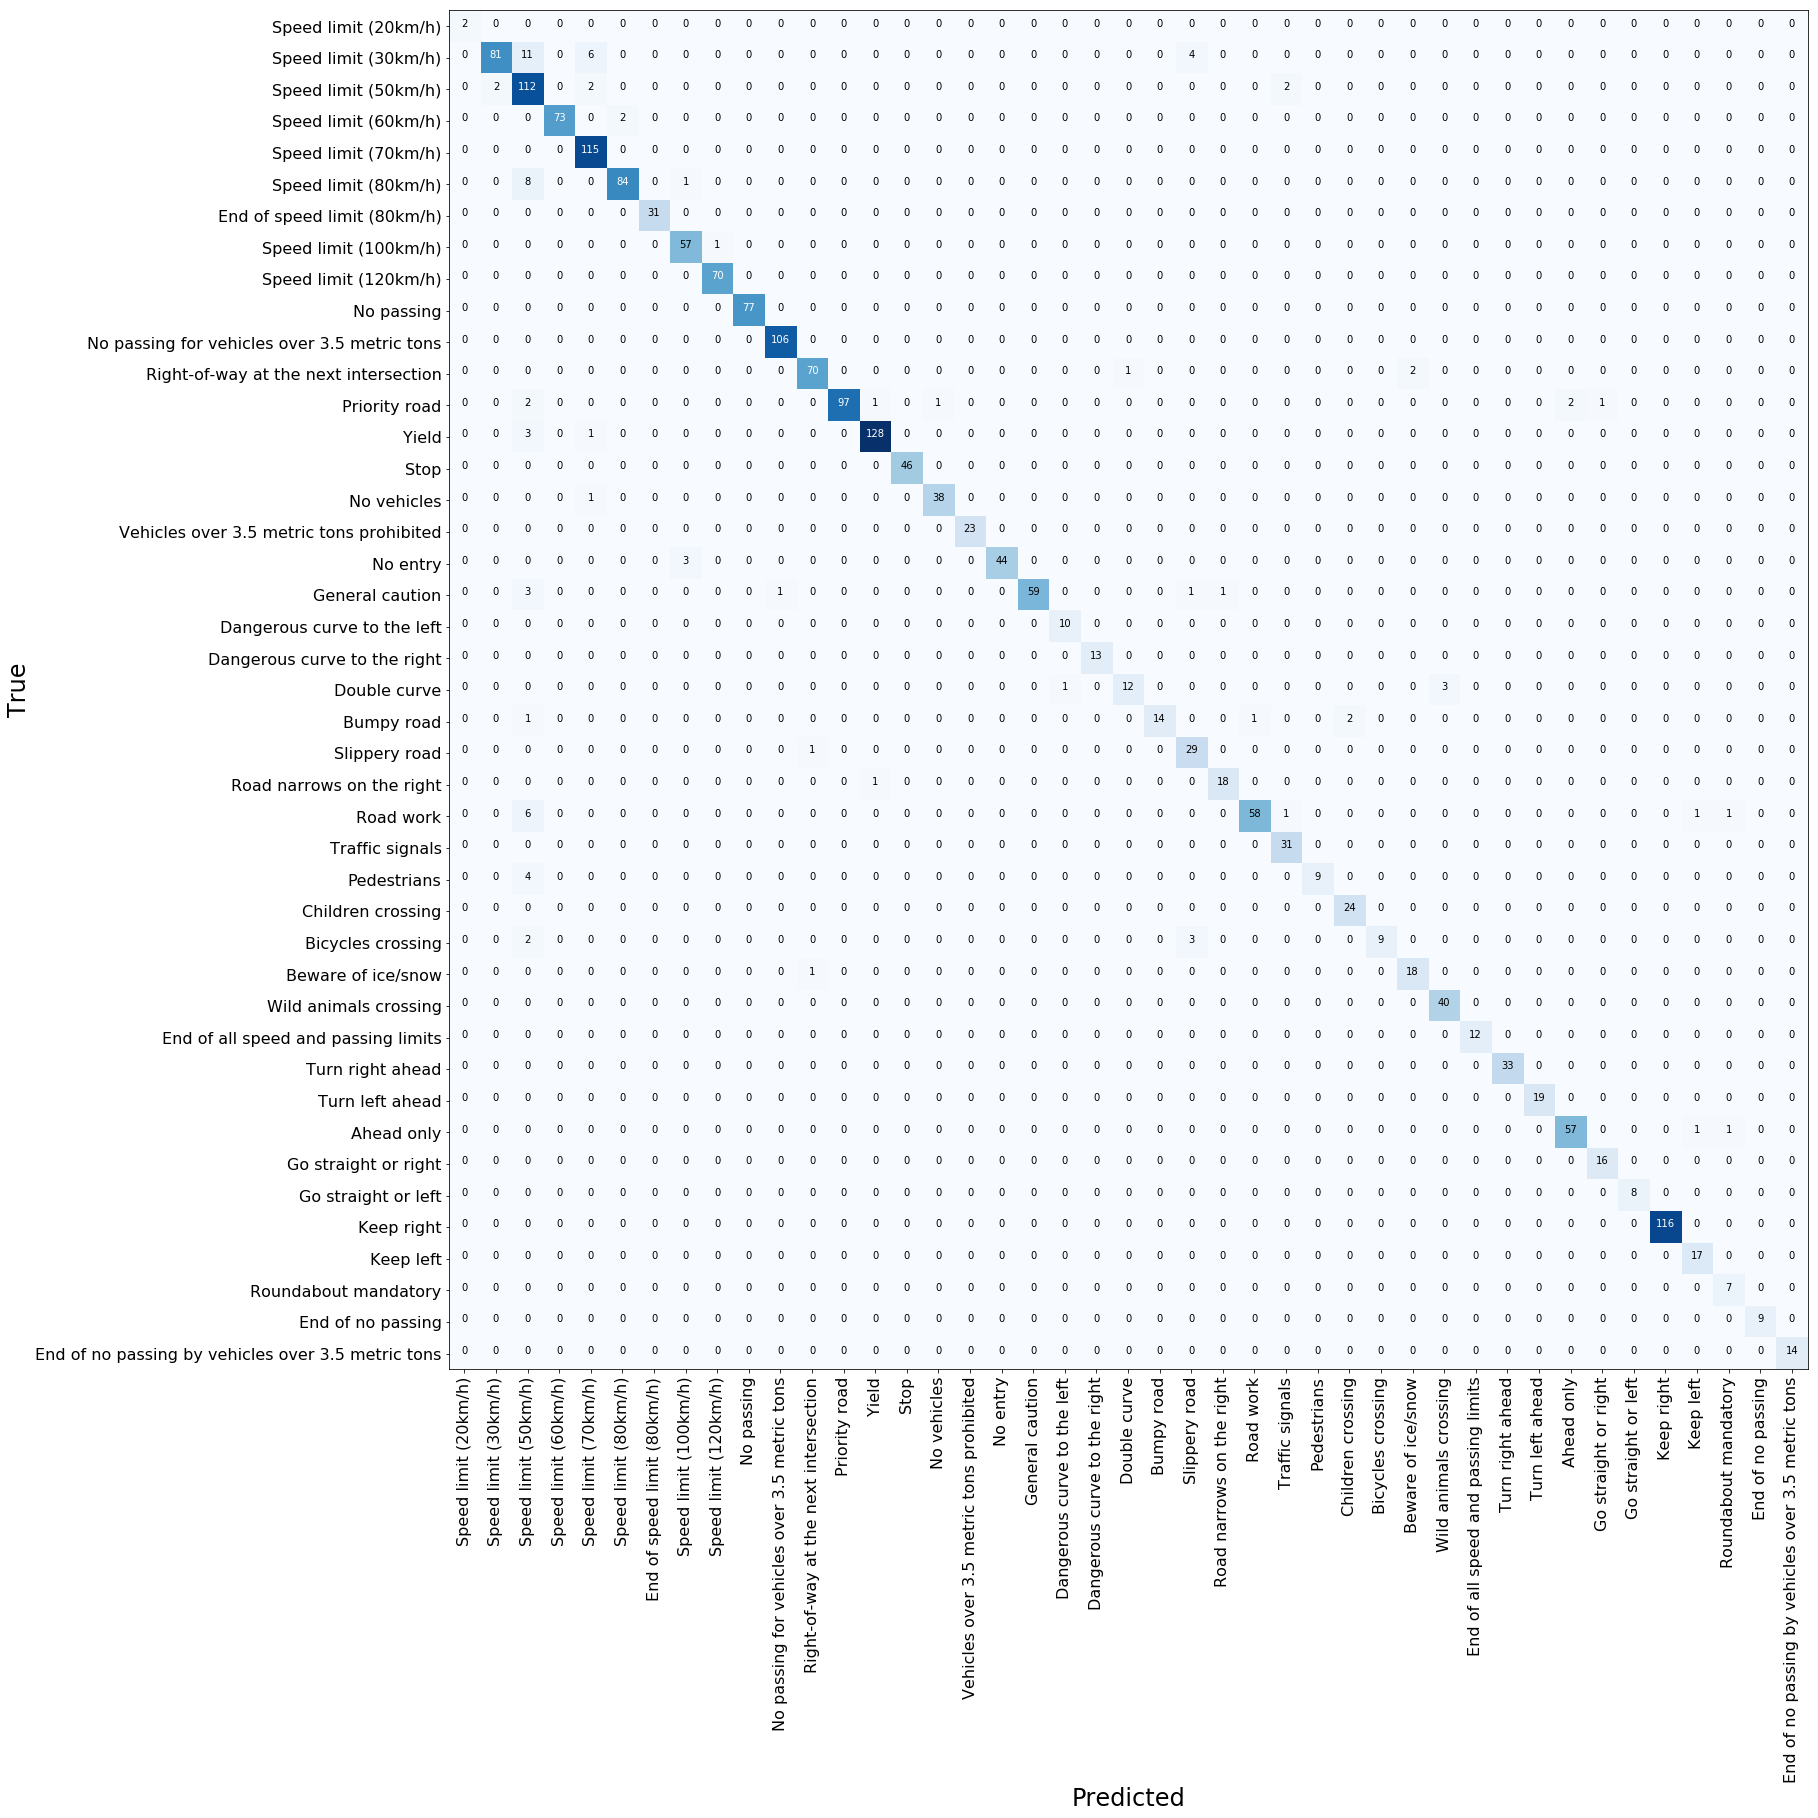

In [15]:
saver=tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess,chkpt)
    plot_confusion_matrix(X_test,y_test, 2000, is_tr= False, normalize=False)

In [17]:
import matplotlib.gridspec as gridspec
from skimage import exposure
from skimage import img_as_ubyte
from skimage import img_as_float
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import argparse
import importlib
import preprocess
importlib.reload(preprocess)
from preprocess import visualize_predictions, image_normalizer, images_show
from tensorflow.python.framework import graph_util

Modules Imported


ImportError: cannot import name 'visualize_predictions'

In [ ]:
###### Load Model and Open 
def run_model(X_,image_names):
    saver=tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        total_pred,top5_pred = sess.run([prediction,top5_guesses], feed_dict={x:X_,is_training: False})
    return total_pred, top5_pred

def test_classifier(img_path):

    Images = [image_normalizer(cv2.imread(img_path+name,1)) for name in os.listdir(img_path) if (name.endswith('.png')  or name.endswith('.jpg'))]
    FileNames = [name for name in os.listdir(img_path) if ( name.endswith('.png') or name.endswith('.jpg') )]
    Images_ = img_as_float(Images)
    print("Processed Images")
    images_show(Images_,1,len(FileNames),rand=False)
    total_pred, top5_pred = run_model(Images_,FileNames)
    visualize_predictions(Images_,FileNames,total_pred, top5_pred)
